# Autoencoder for Image Denoising

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import mnist

## Getting Data

In [4]:
# Since we only need images from the dataset to encode and decode, we
# won't use the labels.
(train_data, _), (test_data, _) = mnist.load_data()

In [7]:
print(train_data.shape, test_data.shape)

(60000, 28, 28) (10000, 28, 28)


## Preprocessing

### Normalize and reshape the data

In [12]:
train_data = train_data.astype('float32') / 255
train_data = tf.reshape(train_data, (len(train_data), 28, 28, 1))

test_data = test_data.astype('float32') / 255 
test_data = tf.reshape(test_data, (len(test_data), 28, 28, 1))

2025-01-08 13:13:24.591665: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-01-08 13:13:24.591762: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-01-08 13:13:24.591770: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-01-08 13:13:24.592365: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-08 13:13:24.592872: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### Create a Copy of the data with added Noise

In [31]:
def noise(array):
    """Adds random noise to each image in the supplied array."""
    noise_factor = 0.5
    noisy_array = array + noise_factor * np.random.normal(
        loc=0.0, scale=1.0, size=array.shape
    )

    return np.clip(noisy_array, 0.0, 1.0)

In [32]:
# Create a copy of the data with added noise
noisy_train_data = noise(train_data)
noisy_test_data = noise(test_data)

In [29]:
def display(array1, array2):
    """Displays ten random images from each array."""
    n = 10
    indices = np.random.randint(len(array1), size=n)
    images1 = array1.numpy()[indices, :]
    images2 = array2[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(image1.reshape(28, 28))
        
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(image2.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

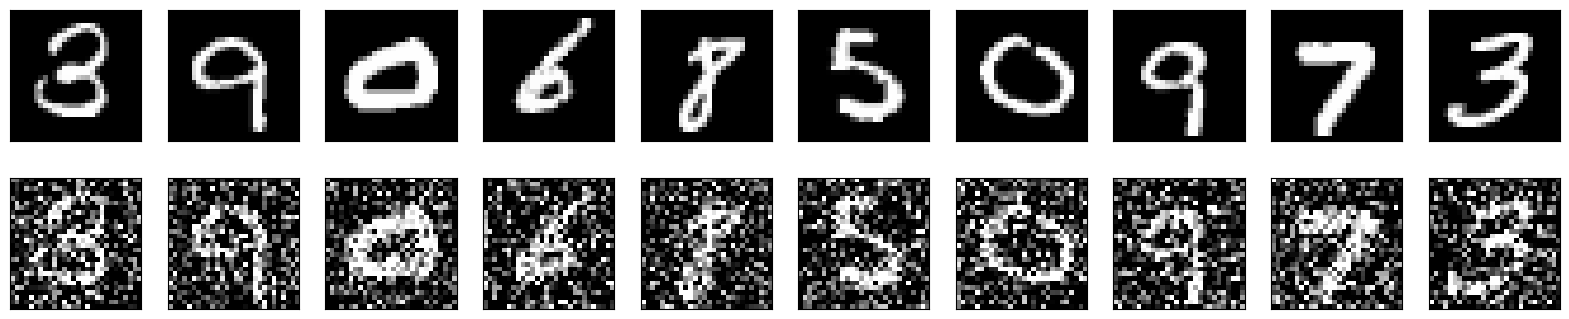

In [33]:
display(train_data,noisy_train_data)

## Model

In [34]:
input = tf.keras.layers.Input(shape=(28, 28, 1))


x = tf.keras.layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input)
x = tf.keras.layers.MaxPooling2D((2, 2), padding="same")(x)
x = tf.keras.layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = tf.keras.layers.MaxPooling2D((2, 2), padding="same")(x)


x = tf.keras.layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = tf.keras.layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = tf.keras.layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)

In [35]:
autoEncoder = tf.keras.Model(input,x)

In [39]:
autoEncoder.compile(optimizer='adam', loss='binary_crossentropy')

In [37]:
autoEncoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 14, 14, 32)     │         9,248 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 28, 28, 32)     │         9,248 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,353 (110.75 KB)

 Trainable params: 28,353 (110.75 KB)

 Non-trainable params: 0 (0.00 B)

In [40]:
autoEncoder.fit(
    x=train_data,
    y=train_data,
    epochs=50,
    batch_size=128,
    shuffle=True,
    validation_data=(test_data, test_data),
)

Epoch 1/50


2025-01-08 15:14:35.988581: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - loss: 0.2509 - val_loss: 0.0724
Epoch 2/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 0.0717 - val_loss: 0.0690
Epoch 3/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 0.0693 - val_loss: 0.0677
Epoch 4/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 0.0680 - val_loss: 0.0669
Epoch 5/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - loss: 0.0674 - val_loss: 0.0663
Epoch 6/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - loss: 0.0668 - val_loss: 0.0659
Epoch 7/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 0.0662 - val_loss: 0.0656
Epoch 8/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - loss: 0.0659 - val_loss: 0.0652
Epoch 9/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - loss: 0.0656 - val_loss: 0.0649
Epoch 10/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 0.0652 - val_loss: 0.0647
Epoch 11/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 0.0651 - val_loss: 0.0645
Epoch 12/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 2

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


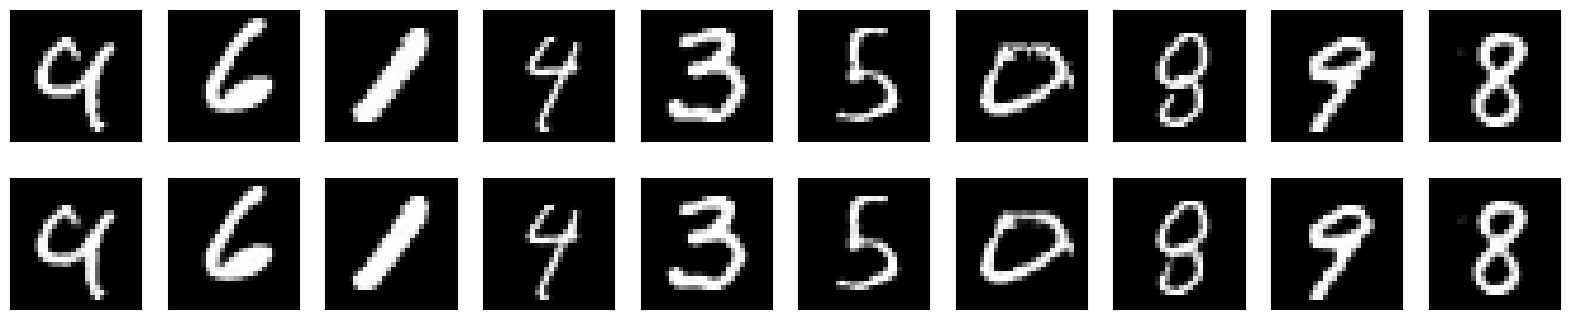

In [42]:
predictions = autoEncoder.predict(test_data)
display(test_data, predictions)

In [43]:
autoEncoder.fit(
    x=noisy_train_data,
    y=train_data,
    epochs=100,
    batch_size=128,
    shuffle=True,
    validation_data=(noisy_test_data, test_data),
)

Epoch 1/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 0.1359 - val_loss: 0.1092
Epoch 2/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 0.1094 - val_loss: 0.1060
Epoch 3/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 0.1065 - val_loss: 0.1044
Epoch 4/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - loss: 0.1048 - val_loss: 0.1031
Epoch 5/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 0.1037 - val_loss: 0.1021
Epoch 6/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 0.1027 - val_loss: 0.1013
Epoch 7/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 0.1021 - val_loss: 0.1007
Epoch 8/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 0.1013 - val_loss: 0.1002
Epoch 9/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 0.1010 - val_loss: 0.0999
Epoch 10/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 0.1004 - val_loss: 0.0996
Epoch 11/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 0.1001 - val_loss: 0.0992
Epoch 12/100
469/469 ━

In [47]:
def display_noise_data(array1, array2):
    """Displays ten random images from each array."""
    n = 10
    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(image1.reshape(28, 28))
        
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(image2.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


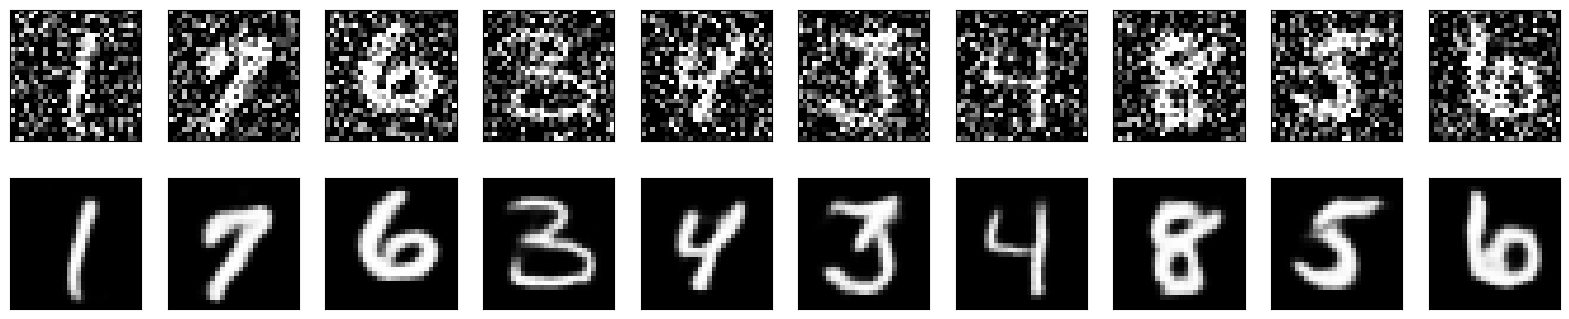

In [48]:
predictions = autoEncoder.predict(noisy_test_data)
display_noise_data(noisy_test_data, predictions)